In [7]:
import warnings
import copy 
import numpy   as np
import pandas  as pd
import seaborn as sea
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore',category=FitFailedWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)

In [6]:
data = pd.read_csv(r'datasets/DiabetesPredictionClassfication/diabetes_prediction_dataset.csv')

In [4]:
data.head(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0


&nbsp;
O nível de HbA1c (hemoglobina A1c) é uma medida do nível médio de açúcar no sangue de uma pessoa nos últimos 2-3 meses. Níveis mais altos

In [6]:
data[data.duplicated()]['diabetes'].value_counts()

diabetes
0    3836
1      18
Name: count, dtype: int64

> Como são muitos valores repetidos serão removidos

&nbsp;

# Analise dos dados

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [79]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Verificando valores nulos no meu conjunto de dados

In [80]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

> Não ha valores  nulos no conj. de dados

### Diabetes

In [81]:
countDiabetes = data['diabetes'].value_counts().reset_index(name='quantidade')

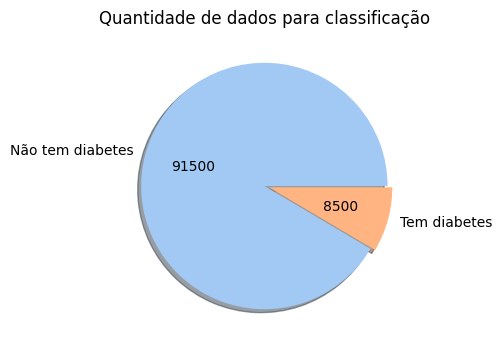

In [82]:
plt.figure(figsize=(5,4))
plt.pie( x = countDiabetes['quantidade'], explode=(0,0.04) , labels = ['Não tem diabetes','Tem diabetes'],autopct=lambda x: '{:.0f}'.format(x*countDiabetes['quantidade'].sum()/100) ,colors=sea.color_palette('pastel')[0:2],shadow=True)
plt.title('Quantidade de dados para classificação')
plt.show()

Os atributo `Diabetes` está desbalanceados com isso para a classificação se faz necessário o balaceamento dele. \
Como as pessoas que não tem diabetes está em mais quantidade ( muito mais) do que as que tem diabetes , irei fazer UnderSampling para o balanceamento dos dados.  

### Gender

In [83]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [84]:
data.loc[data['gender']=='Other'][['diabetes','hypertension','heart_disease','smoking_history']].value_counts().reset_index()

,diabetes,hypertension,heart_disease,smoking_history,count
0,0,0,0,not current,8
1,0,0,0,No Info,6
2,0,0,0,never,3
3,0,0,0,ever,1


Esses dados para pessoa `gender` == `other` são redundantes, os valores dos atributos `hypertension` , `heart_disease` em relação `diabete` não muda continua 0, além de não mudar o valor do atributo `diabetes` continua zero. \
Com isso será removido do conjunto de dados.

In [22]:
data.drop( index = data.loc[ data['gender'] == 'Other'].index , inplace = True )

In [23]:
countGender = data['gender'].value_counts().reset_index(name='Quantidade')

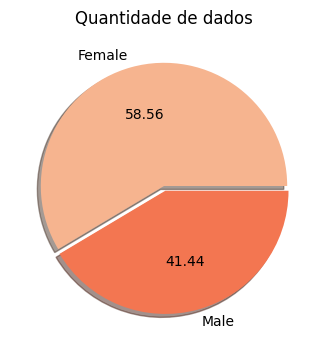

In [87]:
plt.figure(figsize=(10,4))
plt.pie( x = countGender['Quantidade'], explode=(0,0.04) , labels = countGender['gender'] ,colors = sea.color_palette('rocket_r')[0:2] , autopct='%.2f' ,shadow=True )
plt.title('Quantidade de dados')
plt.show()

Possui muito mais dados do genero feminino que o masculino. 

In [88]:
countGenderDiabetes = data.groupby( by=['gender','diabetes'] )['age'].mean().reset_index(name='Média de idade')

In [89]:
SelectDiatebes0 = data.loc[data['diabetes'] == 0][['age','gender']]
SelectDiatebes1 = data.loc[data['diabetes'] == 1][['age','gender']]

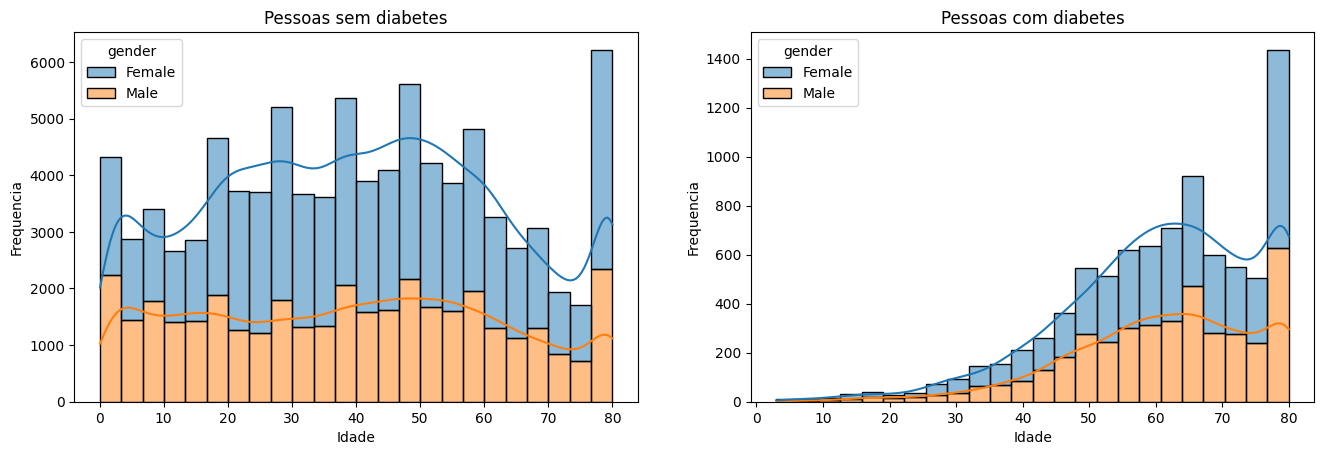

In [90]:
fig , ax = plt.subplots(1,2)
fig.set_figwidth(16)

#Sem diabetes
sea.histplot(
    x = SelectDiatebes0['age'], hue = SelectDiatebes0['gender'] , ax = ax[0] ,multiple="stack", 
    kde = True, shrink = 1 , bins = 24
)
ax[0].set_xlabel('Idade')
ax[0].set_ylabel('Frequencia')
ax[0].set_title('Pessoas sem diabetes')

# Com diabetes
sea.histplot(
    x = SelectDiatebes1['age'], hue = SelectDiatebes1['gender'], ax = ax[1] , multiple="stack", 
    kde= True, shrink=1, bins = 24
)
ax[1].set_xlabel('Idade')
ax[1].set_ylabel('Frequencia')
ax[1].set_title('Pessoas com diabetes')

plt.show()

In [91]:
groupGenHype = data.groupby( by = ['gender'])['hypertension'].value_counts().reset_index(name = 'Quantidade')

In [92]:
groupGenHeart = data.groupby( by = ['gender'])['heart_disease'].value_counts().reset_index(name = 'Quantidade')

In [93]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

groupGenHype['hypertension'].loc[groupGenHype['hypertension'] == 0]     = 'Não tem hipertensão'
groupGenHype['hypertension'].loc[groupGenHype['hypertension'] == 1]     = 'Tem hipertensão'
groupGenHeart['heart_disease'].loc[groupGenHeart['heart_disease'] == 0] = 'Não doença cardiaca'
groupGenHeart['heart_disease'].loc[groupGenHeart['heart_disease'] == 1] = 'Tem doençã cardiaca'

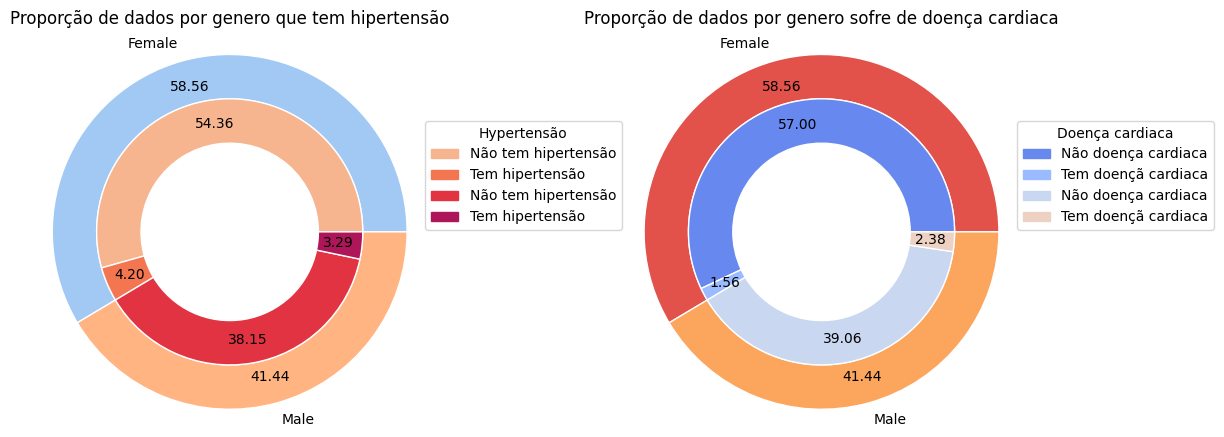

In [94]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
colors1 = sea.color_palette('pastel')[0:2] 
colors2H = sea.color_palette('rocket_r')[0:4] 


ax[0].pie(x = groupGenHype.groupby(by=['gender'])['Quantidade'].sum(), labels= groupGenHype['gender'].drop_duplicates().values ,
       wedgeprops = dict(width=0.3, edgecolor='w'), autopct='%.2f' , pctdistance =0.85 ,colors=colors1 ,radius=1.2)

ax[0].pie(x = groupGenHype.groupby(by=['gender','hypertension'])['Quantidade'].sum() ,wedgeprops=dict(width=0.3, edgecolor='w'),
       radius=.9,autopct='%.2f',pctdistance=0.82 ,colors=colors2H )

colors1 = sea.color_palette('Spectral')[0:2]
colors2 = sea.color_palette('coolwarm')[0:6] 

ax[1].pie(x = groupGenHeart.groupby(by=['gender'])['Quantidade'].sum(), labels= groupGenHype['gender'].drop_duplicates().values ,
       wedgeprops = dict(width=0.3, edgecolor='w'), autopct='%.2f' , pctdistance =0.85 ,colors=colors1 ,radius=1.2)

ax[1].pie(x = groupGenHeart.groupby(by=['gender','heart_disease'])['Quantidade'].sum() ,wedgeprops=dict(width=0.3, edgecolor='w'),
       radius=.9,autopct='%.2f',pctdistance=0.82 ,colors=colors2 )

legends = []
for value, color in zip(groupGenHype['hypertension'].values, colors2H): 
       legends.append(mpatches.Patch(color=color, label=value))

legends2 = []
for value, color in zip(groupGenHeart['heart_disease'].values, colors2): 
       legends2.append(mpatches.Patch(color=color, label=value))

ax[0].legend(title='Hypertensão'    ,handles=legends, bbox_to_anchor=(1.01,0.519,0,0.3))
ax[1].legend(title='Doença cardiaca',handles=legends2, bbox_to_anchor=(1.01,0.519,0,0.3))

ax[0].set_title('Proporção de dados por genero que tem hipertensão',y=1.04)
ax[1].set_title('Proporção de dados por genero sofre de doença cardiaca',y=1.04)

plt.show()

In [95]:
genderGroupby = data\
    .loc[data['diabetes']==1]\
        .groupby(by=['gender','hypertension','heart_disease'])['age']\
            .apply(lambda x:x).reset_index()

In [96]:
genderGroupby = pd.concat(
    [genderGroupby.drop(columns='age'),pd.cut(genderGroupby['age'],20)
     ],axis=1)
genderGroupby.head(3)

,gender,hypertension,heart_disease,level_3,age
0,Female,0,0,6,"(41.5, 45.35]"
1,Female,0,0,53,"(49.2, 53.05]"
2,Female,0,0,59,"(64.6, 68.45]"


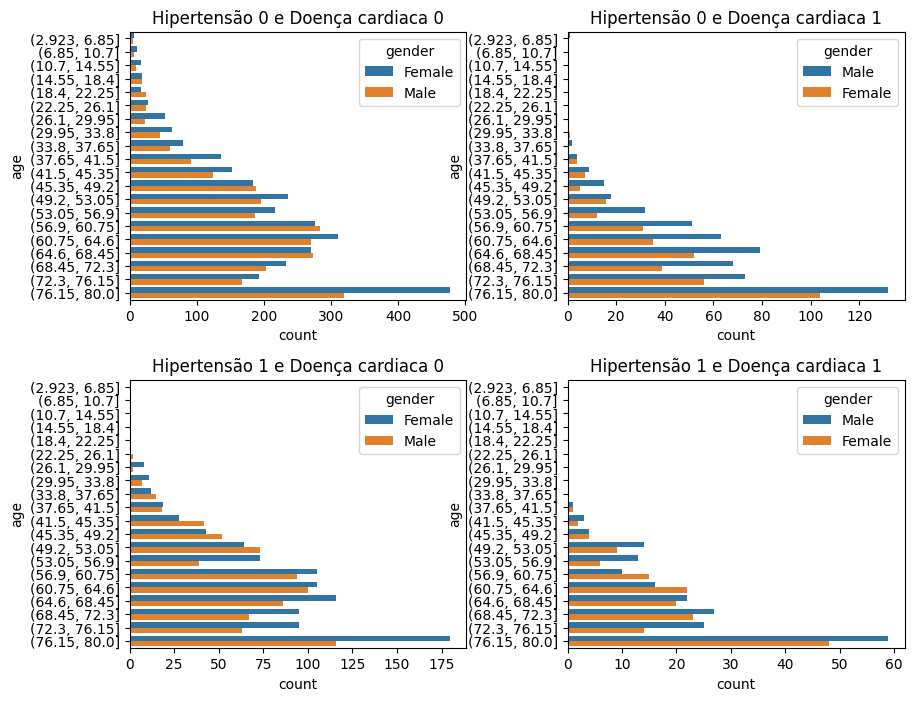

In [97]:
from itertools import product
fig , ax = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in list(product([0,1],repeat=2)):
    select = genderGroupby.loc[ (genderGroupby['hypertension' ]== i[0]) & (genderGroupby['heart_disease']== i[1])
                                ][['age','gender']].value_counts().reset_index() 
    
    ax[i[0],i[1]].set_title(f'Hipertensão {i[0]} e Doença cardiaca {i[1]}')
    sea.barplot(x=select['count'],y=select['age'],hue=select['gender'],orient='h',ax=ax[i[0],i[1]])

> Esse grafico assima e para as pessoas que tem diabetes

### Hipertensão

[]

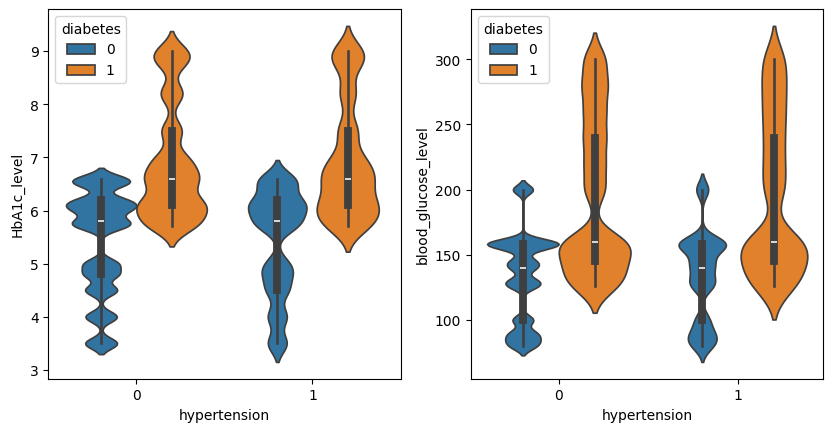

In [43]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(10)
sea.violinplot(x = data['hypertension'] , y= data['HbA1c_level'] , hue=data['diabetes'] ,ax = ax[0])
sea.violinplot(x = data['hypertension'] ,y= data['blood_glucose_level'] , hue=data['diabetes'], ax= ax[1])
plt.plot()

In [ ]:
data.groupby( by = ['smoking_history' ,'diabetes'] )\
    .size()\
        .apply(lambda x:(x*100)/data['smoking_history'].count())\
    .reset_index(name='%')

,smoking_history,diabetes,%
0,No Info,0,34.362
1,No Info,1,1.454
2,current,0,8.338
3,current,1,0.948
4,ever,0,3.532
5,ever,1,0.472
6,former,0,7.762
7,former,1,1.590
8,never,0,31.749
9,never,1,3.346


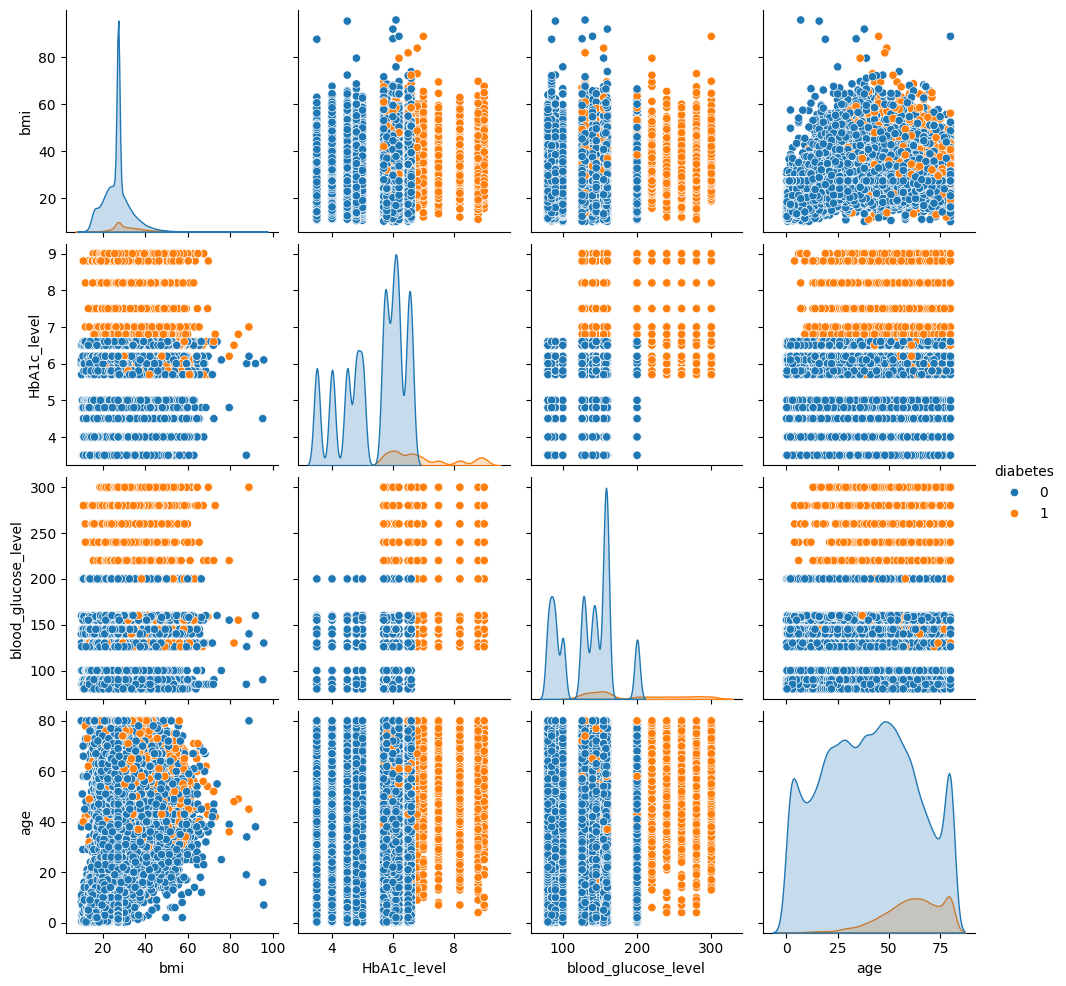

In [5]:
sea.pairplot(data[['bmi','diabetes','HbA1c_level','blood_glucose_level','age']], hue='diabetes')

### Correlação

A classe abaixo verifica a correlação entre :
* Valores binario e númericos
* Valores binarios e categoricos

In [15]:
from scipy.stats import  pointbiserialr
from scipy.stats.contingency import chi2_contingency, association 

class Correlation:
    M_ = None
    
    def __init__(self, column1:list, column2:list, data:pd.DataFrame):
        self.column_names1 = column1
        self.column_names2 = column2
        self.data          = data
        self.tupla         = ( len(column1) , len(column2) ) 
        self.M_ = np.zeros(shape=self.tupla)    

    def cramerV(self):
        for enum_i, i in enumerate(self.column_names1):
            for enum_j, j in enumerate(self.column_names2):

                subset = pd.crosstab(self.data[i].values, self.data[j].values)
                metrica = association(observed=subset, method='cramer')
                self.M_[enum_i, enum_j] = metrica

        return pd.DataFrame(
            data    = self.M_.T, 
            columns = self.column_names1, 
            index   = self.column_names2
        )
    
    def pointBisserl(self):        
        for enum_i, i in enumerate(self.column_names1):
            for enum_j, j in enumerate(self.column_names2):

                corr, _ = pointbiserialr(self.data[i].values, self.data[j].values)
                self.M_[enum_i, enum_j] = corr

        return pd.DataFrame(
            data    = self.M_.T, 
            columns = self.column_names1, 
            index   = self.column_names2
        )

> Para a correlacao entre valores categoricos - numericos primeiro os dados categoricos serão passados para numericos

### Discretização para bmi
Passarei o bmi para valores categoricos e depois ver a correlação entre os atributos
* < 18.5 : baixo do peso
* 18.5 - 24.9 : peso normal
* 25.0 - 29.9 : acima do peso
* 30.0 - 34.9 : obesidade 1
* 35.0 - 39.9 : obesidade 2
* 40 > : obesidade 3

> será usada no pipeline

In [17]:
freq   = [0, 18.5, 25.0, 30.0, 35.0, 40.0, np.max(data['bmi'])]
labels = [
    'baixo do peso', 'peso normal', 
    'acima do peso', 'obesidade 1', 
    'obesidade 2'  , 'obesidade 3'
    ]
data['bmi_cat'] = pd.cut(x=data['bmi'], bins=freq, labels=labels)

#### correlação

In [26]:
col = ['diabetes','heart_disease','gender','smoking_history','hypertension','bmi_cat']
corr3 = Correlation(col, col, data).cramerV()

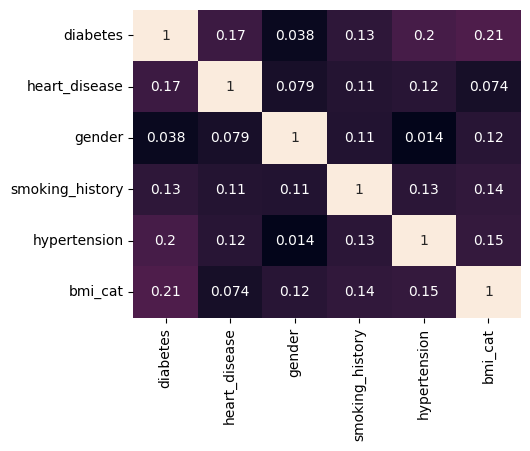

In [27]:
plt.figure(figsize=(5,4))
sea.heatmap(corr3, annot=True, cbar=False)
plt.show()

> Usarei o bmi categerico ao invés do bmi numerico

### Pré-processamento

In [8]:
data = pd.read_csv(r'datasets/DiabetesPredictionClassfication/diabetes_prediction_dataset.csv')

In [15]:
data.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


criei classe que será utilizada em uma pipeline para o pré-processamento dos dados assim facilita e automatiza o processo

Usarei a Sklearn que possibilita fazer esse processo.

In [16]:
from sklearn.base          import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline      import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report,
    accuracy_score       ,
    confusion_matrix     ,
)

importando libs para validação cruzada e melhorando os classificadores

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

importando algoritmo de ml que irei utilizar

In [18]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier, VotingClassifier

Criando uma class Padronizacao dos atributos numericos, alguns algoritmos de Machine Learning precisam que os dados sejam padronizados para melhor desempenho do algoritmo e para convergencia como no Gradiente Descendente(```SGDClassifier```)

In [19]:
class Padronizacao(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):  
        for column in self.columns:
            X[column] = StandardScaler()\
                .fit_transform(X[column].values.reshape(-1, 1))
        return X

LabeEncoder dos atributos categoricos ele irá transformar os atributos categoricos em numericos

In [20]:
class AtributosEncoder(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = LabelEncoder()\
                .fit_transform(X[column].values.reshape(-1, 1))
        return X   

Dummies dos atributos categoricos

In [21]:
class Dummies(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self, X, y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        return pd.get_dummies(X,columns=self.columns,dtype=int)

Removendo atributos

In [22]:
class RemovendoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list) -> None:
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop(columns=self.columns,axis=0)

discretização

In [23]:
class Discretização(BaseEstimator, TransformerMixin):
    '''
    column: é a coluna que deseja discretizar
    name  : Nome da nova coluna
    bins  : é o intervalo ou lista de intervalos
    labels: Valores categoricos
    '''
    def __init__(self, column:str, name:str,bins:list, labels:list=None) -> None:
        self.column = column
        self.name   = name
        self.bins   = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self
    
    def transform(self, X:pd.DataFrame, y=None):
        label = None if labels == None else self.labels
        new_column   = pd.cut( x=X[self.column], bins = self.bins, labels = label )
        X[self.name] = new_column        
        return X     

Pipeline
* Os dados serão pré-processados em uma pipeline assim automatiza o processo e facilita pois posso reutiliza-los no futuro

In [24]:
freq   = [0, 18.5, 25.0, 30.0, 35.0, 40.0, np.max(data['bmi'])]
labels = ['baixo do peso', 'peso normal','acima do peso', 'obesidade 1', 
          'obesidade 2'  , 'obesidade 3']

In [25]:
pipeline = Pipeline(
    steps=[
        ('Padronizacao'     ,
            Padronizacao(['age','HbA1c_level','blood_glucose_level'])),
        ('Discretização'    ,
            Discretização('bmi', 'bmi_cat',bins=freq, labels=labels)),
        ('RemovendoAtributo', 
            RemovendoAtributos(['bmi'])),
        ('LabelEncoder'     ,
            AtributosEncoder(
                ['smoking_history', 'bmi_cat','gender','hypertension','heart_disease']
                )
         ),
        ('Dummies',
            Dummies(['smoking_history', 'bmi_cat', 'gender', ])
        )
    ]
)

In [26]:
dataset = pipeline.fit_transform(data)

/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning

In [27]:
dataset['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

Definindo valor alvo e features

In [28]:
X = dataset.drop(columns=['diabetes'])
y = dataset['diabetes']

Definindo conj. de teste e de treinameto

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(
    X.values,
    y.values,
    test_size=0.25,
    random_state=42
)

In [33]:
xtrain.shape

(75000, 20)

Usando o keras

In [29]:
import keras

2024-04-27 18:12:18.991227: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 18:12:19.030982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 18:12:19.031015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 18:12:19.032130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 18:12:19.038971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 18:12:19.039578: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [27]:
from functools import partial
def Model():
    Dense = partial(
        keras.layers.Dense,
        activation         = keras.activations.elu,
        kernel_initializer = keras.initializers.he_normal,   
    )
    model = keras.models.Sequential(
        layers=[
            Dense(40),
            keras.layers.Dropout(rate=0.1),
            Dense(20),
            keras.layers.Dropout(rate=0.1),
            Dense(10),
            keras.layers.Dropout(rate=0.1),
            Dense(5),
            Dense(3),
            Dense(1),
        ]
    )
    model.compile(
        optimizer = keras.optimizers.Adamax(),
        loss      = keras.losses.binary_crossentropy,
    )

    return model

In [242]:
s = len(xtrain) // 20
model = Model()

stopping  = keras.callbacks.EarlyStopping(monitor='loss', patience=3, start_from_epoch=3)
history  = model.fit(
    xtrain, ytrain, batch_size=32, epochs=15, validation_split=0.1,
    callbacks=[stopping]
)

Epoch 1/15


2110/2110 [==============================] - 5s 2ms/step - loss: 0.5741 - val_loss: 0.3396
Epoch 2/15
2110/2110 [==============================] - 4s 2ms/step - loss: 0.3669 - val_loss: 0.2755
Epoch 3/15
2110/2110 [==============================] - 4s 2ms/step - loss: 0.2985 - val_loss: 0.2648
Epoch 4/15
2110/2110 [==============================] - 4s 2ms/step - loss: 0.2797 - val_loss: 0.2032
Epoch 5/15
2110/2110 [==============================] - 3s 2ms/step - loss: 0.2464 - val_loss: 0.2215
Epoch 6/15
2110/2110 [==============================] - 4s 2ms/step - loss: 0.2468 - val_loss: 0.2077
Epoch 7/15
2110/2110 [==============================] - 4s 2ms/step - loss: 0.2400 - val_loss: 0.1947
Epoch 8/15
2110/2110 [==============================] - 4s 2ms/step - loss: 0.2337 - val_loss: 0.2013
Epoch 9/15
2110/2110 [==============================] - 5s 3ms/step - loss: 0.2373 - val_loss: 0.1961
Epoch 10/15
2110/2110 [==============================] - 7s 3ms/step - loss: 0.2251 - val_los

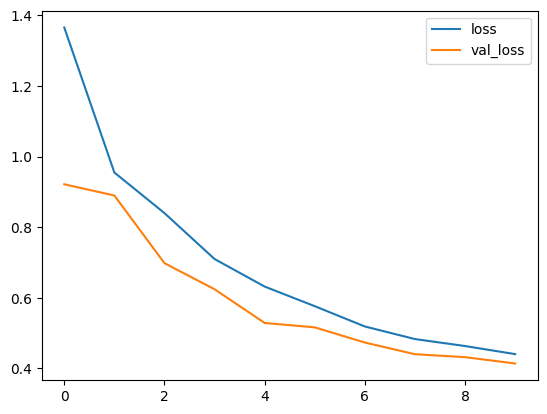

In [232]:
pd.DataFrame(history.history).plot()
plt.show()

In [233]:
predNetwork = model.predict(xtest)>0.5

782/782 [==============================] - 2s 2ms/step


In [235]:
print(classification_report(ytest, predNetwork))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     22850
           1       0.88      0.59      0.71      2150

    accuracy                           0.96     25000
   macro avg       0.92      0.79      0.84     25000
weighted avg       0.96      0.96      0.95     25000



### Arvore de decisão

Vou usar o gridsearch para encontrar o melhor hiperparametro para arvore de decisão

In [28]:
params = dict(
    max_depth    = np.arange(3,30),
    max_features = [10],
    max_leaf_nodes = [100,150,200],
    min_samples_split = [150,200]
    
)
gridTree = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),param_grid=params,scoring='accuracy')
gridTree.fit(xtrain,ytrain)

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'max_features': [10],
                         'max_leaf_nodes': [100, 150, 200],
                         'min_samples_split': [150, 200]},
             scoring='accuracy')

In [29]:
print('Melhor Parametro para o algoritmo:\n',gridTree.best_estimator_)
print(gridTree.best_score_)

Melhor Parametro para o algoritmo:
 DecisionTreeClassifier(criterion='entropy', max_depth=17, max_features=10,
                       max_leaf_nodes=150, min_samples_split=200)
0.97212


In [39]:
tree =  RandomForestClassifier(
    criterion='entropy', max_depth=22, 
    max_features=10, max_leaf_nodes=200, min_samples_split=150
    )
tree.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy', max_depth=22, max_features=10,
                       max_leaf_nodes=200, min_samples_split=150)

In [40]:
predTree = tree.predict(xtest)

In [41]:
print(classification_report(ytest, predTree))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22850
           1       1.00      0.67      0.80      2150

    accuracy                           0.97     25000
   macro avg       0.98      0.83      0.89     25000
weighted avg       0.97      0.97      0.97     25000



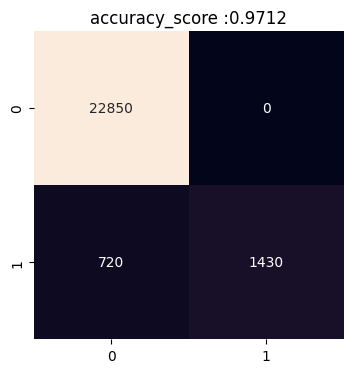

In [42]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predTree), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predTree)}')
plt.show()

### Regressão Logisticas

In [43]:
logistic = LogisticRegression(penalty='l2',solver='newton-cholesky',l1_ratio=1,max_iter=1000,tol=1e-6)
logistic.fit(xtrain,ytrain)

/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


LogisticRegression(l1_ratio=1, max_iter=1000, solver='newton-cholesky',
                   tol=1e-06)

In [44]:
predLog = logistic.predict(xtest)

In [45]:
print(classification_report(ytest, predLog))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     22850
           1       0.87      0.62      0.72      2150

    accuracy                           0.96     25000
   macro avg       0.92      0.80      0.85     25000
weighted avg       0.96      0.96      0.96     25000



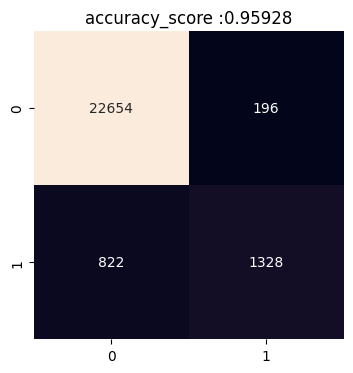

In [253]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predLog), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predLog)}')
plt.show()

### knn

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
knn = KNeighborsClassifier()
knn.fit(xtrain,ytrain)

KNeighborsClassifier()

In [35]:
predKnn = knn.predict(xtest)

In [36]:
print(classification_report(ytest, predKnn))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     22850
           1       0.90      0.60      0.72      2150

    accuracy                           0.96     25000
   macro avg       0.93      0.80      0.85     25000
weighted avg       0.96      0.96      0.96     25000



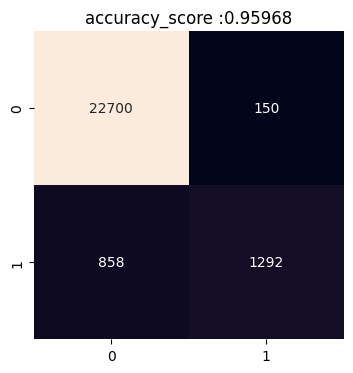

In [37]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predKnn), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predKnn)}')
plt.show()